# Simple Recurrent Neural Networks

In this notebook we will use a Simple Recurrent Neural Network (RNN) to predict a health care time series.  Although the method is called 'simple' RNN's are more complicated than the Feedforward Neural Networks we have already used.  

>Note that increased complexity does not always come with improved performance!

<div class="alert alert-success">
    
1. The data preprocessing requirements for a RNN are almost identical to feedforward networks.
    
2. Feedforward networks expected X_train data in two dimensions (n_time_steps, window_size). In contrast, RNNs expect X_train data in three dimensions (n_time_steps, window_size, n_features).

2. In practice, forecasting **h-steps** ahead is best achieved by predicting a target vector.
</div>

---
**LEARNING OBJECTIVES**

* Understand how to use Keras to build a SimpleRNN
* Learn the important of the shape of input data for an RNN.
* Generate h-step forecasts using an iterative approach
* Use a ensemble of SimpleRNNs to produce a better forecast.
---


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided for this work. We are going to implement neural networks using `tensorflow` and '`keras`. You should be using at least `tensorflow` version `2.1.0`.

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dense, Flatten, SimpleRNN, 
                                     LSTM, GRU, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler

tf.__version__

'2.1.0'

## 2. Dataset: Emergency admissions in England

We will again use the monthly emergency admissions in England dataset.  

### 2.1 Load and preprocess data

**Summary of the code below**:
* Reads the ed_admits dataset.
* Parses the date column
* Calender adjusts the data
* Standardises the data between -1 and 1 using MinMaxScaler
* Converts the time series to a supervised learning problem with window_size 12 and target vector length 12

In [15]:
url = 'https://raw.githubusercontent.com/health-data-science-OR/data/master/em_admits_ts.csv'
em_admits = pd.read_csv(url)
date_str = em_admits['month_year'].str[:3] + ' 20' + em_admits['month_year'].str[-2:]
date_str.name = 'date'
em_admits = em_admits.set_index(pd.to_datetime(date_str))
em_admits.index.freq = 'MS'
em_admits = em_admits.drop(columns=['month_year'])
admit_rate = em_admits['em_admits'] / em_admits.index.days_in_month


In [7]:
def sliding_window(train, window_size=2, horizon=2):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=2)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        #we use list slicing to return a vector of training for y_train
        y_train = train[i+window_size:i+window_size+horizon]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
    
    return np.asarray(tabular_X), np.array(tabular_y)

> It is critical that we get the X training data into the correct shape.  The function `sliding_window` generates a 2D array (n_time_steps, window_size).  Off the array call the `.reshape(-1, WINDOW_SIZE, 1)` function. 

In [17]:
#preprocess time series training and test sets
WINDOW_SIZE = 12
HORIZON = 12
TRAIN_LENGTH = 56

scaler = MinMaxScaler(feature_range=(-1, 1))

#I am scaling on admit_rate because this will include the first 12 lags 
#not in y_train
scaler.fit(admit_rate.iloc[:-12].to_numpy().reshape(-1, 1))
admit_rate_adj = scaler.transform(admit_rate.to_numpy().reshape(-1, 1))

#convert to supervised learning problem
X_train, y_train = sliding_window(admit_rate_adj, 
                                  window_size=WINDOW_SIZE,
                                  horizon=HORIZON)

#This is the key part we reshape to a 3D representation 
#(n_time_steps, window_size, n_features)
X_train = X_train.reshape(-1, WINDOW_SIZE, 1)

#train-test split
X_train, X_test = X_train[:TRAIN_LENGTH], X_train[TRAIN_LENGTH:]
y_train, y_test = y_train[:TRAIN_LENGTH], y_train[TRAIN_LENGTH:]

> Check `X_train` and `X_test` shapes

In [19]:
X_train.shape

(56, 12, 1)

In [20]:
X_test.shape

(31, 12, 1)

## Compiling a SimpleRNN in Keras

In Keras, we built a multi-layered feedforward neural network for time series like so:
```python

HORIZON = 12
WINDOW_SIZE = 12

model = Sequential()
model.add(Input(shape=(WINDOW_SIZE, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(HORIZON))
model.compile(optimizer=Adam(lr=0.01), loss='mse')
```
Keras provides an RNN layer

```Python
tensorflow.keras.layers.SimpleRNN
```

To build the RNN we just replace the first `Dense` layer with the `SimpleRNN` class from Keras:

```python
model = Sequential()
model.add(Input(shape=(WINDOW_SIZE, 1)))
model.add(SimpleRNN(units=100, activation='tanh'))
model.add(Dense(HORIZON))
...
```

>Note that the default activation function for `SimpleRNN` is the hyperbolic tangent (tanh).  In practice you may want to compare the result to an RNN using a Linear Rectifier (ReLU)

### Exercise: Create a SimpleRNN model.

* Create a function called `get_simple_rnn()`  
* The function will build and compile a SimpleRNN model.
* The function should accept the parameters
 * window_size: int, the number lags of the time series included in each training observation
 * n_units: int, the number of units to include in the RNN. An optional paramter (default=100)
 * activation: str, the SimpleRNN activation function. An optional parameter (efault is 'tanh')
 * The function must return a compiled Keras model.

In [22]:
def get_simple_rnn(window_size, n_units=10, activation='tanh'):
    '''
    Build and compile a simple RNN in Keras
    
    Parameters:
    -------
    window_size: int, 
        the number lags of the time series included in each training observation
    
    n_units: int, optional (default=100)
        the number of units to include in the RNN.
    
    activation: str, optional (default='tanh')
        the SimpleRNN activation function.
    
    Returns:
    ------
    A compiled Keras model.
    '''
    model = Sequential()
    model.add(Input(shape=(window_size, 1)))
    model.add(SimpleRNN(n_units, activation=activation))
    model.add(Dense(window_size))
    model.compile(optimizer=Adam(lr=0.01), loss='mse')
    return model

## Training the SimpleRNN

Training is the same as feedforward neural networks.  The code below illustrates how to do this.

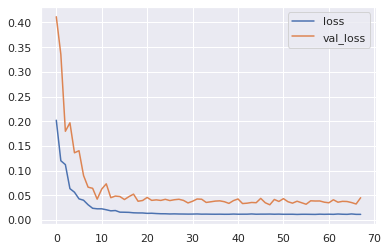

In [42]:
#set tensorflow random seed for repeatability
tf.random.set_seed(42)

N_EPOCHS = 100

#It might be worth experimenting with early stopping by varying @patience
es = EarlyStopping(monitor='val_loss', patience=20,
                  restore_best_weights=True)

#this will only work if you have coded get_simple_rnn correctly!
model = get_simple_rnn(12, n_units=100, activation='tanh')

#train the model silently (verbose=0)
history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[es])

#plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Forecasting with the RNN

> There are a couple of points to remember when forecasting.  The first is that an RNN expects a 3D input array.  The second is that we we trained our SimpleRNN to predict a vector of length 12.  

In [70]:
y_preds = model.predict(X_test[0].reshape(1, WINDOW_SIZE, -1))[0]
y_preds

array([0.21092385, 0.18012631, 0.26051328, 0.27530977, 0.06043413,
       0.34697577, 0.24772435, 0.43037206, 0.3691437 , 0.36007485,
       0.45820516, 0.38549894], dtype=float32)

In [71]:
#back transform the predictions
scaler.inverse_transform(y_preds.reshape(-1, 1))

array([[15889.507],
       [15822.216],
       [15997.858],
       [16030.188],
       [15560.691],
       [16186.776],
       [15969.915],
       [16368.994],
       [16235.212],
       [16215.396],
       [16429.809],
       [16270.947]], dtype=float32)

In [75]:
#back transform the matching y_test vector
scaler.inverse_transform(y_test[0].reshape(-1, 1))

array([[15340.3       ],
       [15909.38709677],
       [16007.        ],
       [15813.58064516],
       [15179.16129032],
       [15860.26666667],
       [15902.67741935],
       [16310.86666667],
       [16061.77419355],
       [15879.77419355],
       [15988.85714286],
       [16445.32258065]])

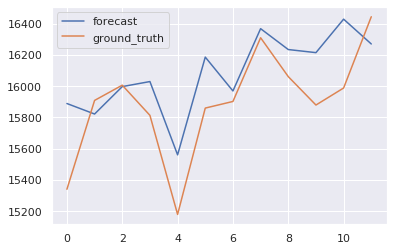

In [78]:
#plot the two predictions on the same chart
plt.plot(scaler.inverse_transform(y_preds.reshape(-1, 1)), 
         label='forecast')
plt.plot(scaler.inverse_transform(y_test[0].reshape(-1, 1)), 
         label='ground_truth')
plt.legend()

## Making a h-step forecast using an RNN that predicts a vector.

We again use the iterative method for forecasting, but need to remember that we are predicting vectors on each iteration.  If our vector is of length 12 and we we want to predict 24 months ahead then we make 2 iterative predictions.  

>This is the same method we used with feedforward networks.  The function `vector_iterative_forecast` is very similar, but the key difference is that an RNN expects 3D data where ANN expected 2D. 

In [80]:
def vector_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        
        #this is the key change we are resizing to 3D
        y_pred = model.predict(current_X.reshape(1, WINDOW_SIZE, -1))[0]
        y_preds.append(y_pred)
        
        #current_X = np.roll(current_X, shift=-h)
        #current_X[-h] = y_pred.copy()
        current_X = y_pred.copy()

    return np.concatenate(np.array(y_preds))

In [81]:
#code to help plotting

def plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds):  
    
    #create series
    fitted_values = scaler.inverse_transform(model.predict(X_train))
    ground_truth = scaler.inverse_transform(y_train)
    ground_truth_val = scaler.inverse_transform(y_test)

    padding = np.full(len(fitted_values), np.NAN)

    validation = np.concatenate([padding.reshape(-1, 1), ground_truth_val])
    forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

    plt.plot(ground_truth, label='ground truth')
    plt.plot(validation, label='test')
    plt.plot(fitted_values, label='in-sample', linestyle='-.')
    plt.plot(forecast, label='out-of-sample', linestyle='-.')
    plt.legend();

In [86]:
#predict next 24 months and plot (2 vector lengths)
H = 24
VECTORS_AHEAD = H // WINDOW_SIZE

y_preds = vector_iterative_forecast(model, X_test[0], h=VECTORS_AHEAD)
y_preds = scaler.inverse_transform(y_preds.reshape(-1, 1))

#plot_nn_prediction_results(model, X_train, y_train, y_test[0], y_preds)

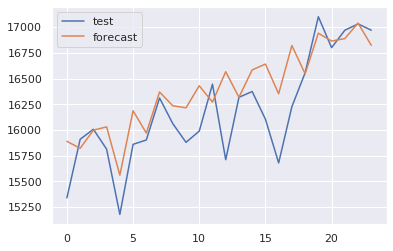

In [88]:
y_test_to_plot = []
for i in range(VECTORS_AHEAD):
    y_test_to_plot.append(y_test[WINDOW_SIZE*i])
y_test_to_plot = np.concatenate(y_test_to_plot)

y_test_to_plot = scaler.inverse_transform(y_test_to_plot.reshape(-1, 1))   
plt.plot(y_test_to_plot, label='test')
plt.plot(y_preds, label='forecast')
plt.legend();

In [89]:
rmse_rnn = rmse(scaler.inverse_transform(y_test[0].reshape(-1, 1)), y_preds.T[:H])[0]
print(f'rmse RNN: {rmse_rnn:.2f}')

rmse RNN: 335.82


In [ ]:
## Experimenting with the SimpleRNN

**Exercise**: 

Select a number of training epochs (e.g. 100-200) and try the following experiments to explore how the SimpleRNN behaves (note in all of these window_size is 12)
* n_units=100, activation='tanh'
* n_units=150, activation='tanh'
* n_units=100, activation='relu'
* n_units=150, activation='relu'

**Hints:**
* Remember to plot the training and validation loss
* 

In [220]:
# Exercise create an ensemble of SimpleRNNs

In [242]:
#set tensorflow random seed for repeatability
tf.random.set_seed(1066)

N_MODELS = 30
N_EPOCHS = 100
N_UNITS = 100
H = 12
VECTORS_AHEAD = H // WINDOW_SIZE

es = EarlyStopping(monitor='loss', patience=10)
BATCH_SIZE = 32

models = []
for n in range(N_MODELS):
    #SimpleRNN model
    model_n = model = get_simple_rnn(WINDOW_SIZE, 
                                     n_units=N_UNITS, 
                                     activation='tanh')

    #fit model silently
    history = model_n.fit(x=X_train, 
                          y=y_train, 
                          epochs=N_EPOCHS,
                          verbose=0, 
                          callbacks=[es], 
                          batch_size=BATCH_SIZE)

    #this will overwrite pre-trained models.
    #model_n.save(f'output/mlp_ensemble_{n}.h5')
    models.append(model_n)

In [243]:
#this code will take a few seconds to execute
H = 1
e_preds = []
for model in models:
    y_preds = vector_iterative_forecast(model, X_test[0], h=H)
    e_preds.append(y_preds)
    
e_preds = np.array(e_preds)

In [244]:
e_preds = np.asarray(e_preds)
e_preds_tran = scaler.inverse_transform(e_preds).T
y_preds_mdn = np.percentile(e_preds_tran.T, 50, axis=0)
y_preds_2_5 = np.percentile(e_preds_tran.T, 2.5, axis=0)
y_preds_97_5 = np.percentile(e_preds_tran.T, 97.5, axis=0)
y_preds_mdn.shape

(12,)

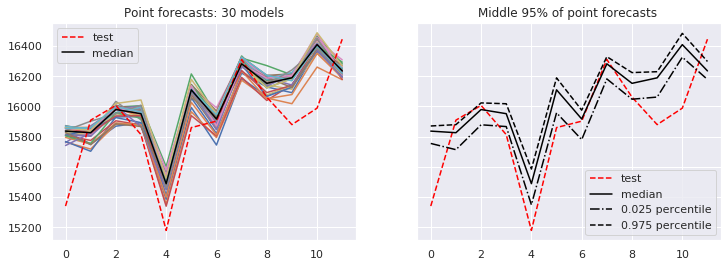

In [245]:
#plot the individual forecasts and the median

fig,ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax[0].plot(e_preds_tran)
ax[0].plot(scaler.inverse_transform(y_test[0]), label='test', linestyle='--', 
         color='red')
ax[0].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[0].legend()
ax[0].set_title(f'Point forecasts: {N_MODELS} models')

ax[1].plot(scaler.inverse_transform(y_test[0]), label='test', linestyle='--', 
         color='red')
ax[1].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[1].plot(y_preds_2_5, label='0.025 percentile', linestyle='-.', color='black')
ax[1].plot(y_preds_97_5, label='0.975 percentile', linestyle='--', color='black')

ax[1].set_title(f'Middle 95% of point forecasts ')
ax[1].legend();

In [246]:
rmse_rnn_mdn = rmse(scaler.inverse_transform(y_test[0].reshape(-1, 1)), y_preds_mdn)[0]

print(f'rmse RNN: {rmse_rnn_mdn:.2f}')

rmse RNN: 340.26


In [ ]:
def get_lstm(window_size, n_units=10, activation='tanh'):
    model = Sequential()
    model.add(Input(shape=(window_size, 1)))
    model.add(Conv1D(24, 6))
    model.add(LSTM(n_units, activation=activation))
    #model.add(GlobalMaxPool1D())
    model.add(Dense(window_size))
    model.compile(optimizer=Adam(lr=0.01), loss='mse')
    return model